In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

import string

from wordcloud import STOPWORDS

### Loading data and basic EDA
##### steps for this notebook:
1. data analysis
2. feature engineering ideas
3. cleaning data 
4. baseline BERT

In [2]:
#Load the data

train_path = '../../data/disaster_tweets/train.csv'
test_path = '../../data/disaster_tweets/test.csv'

train_df = pd.read_csv(train_path, dtype={'id': np.int16, 'target': np.int8})
test_df = pd.read_csv(test_path, dtype={'id': np.int16})

In [3]:
print('train shape = ', train_df.shape)
print('test shape = ', test_df.shape)

train shape =  (7613, 5)
test shape =  (3263, 4)


### 1. missing values in test and training for all columns
        - fill with some kinda values: for example: no_keyword, no_location
        - locations are cardinal and has too many unique values --> can't be used as feature
        - plot keyword values and distribution - accompany target with the keyword (plot a histogram with target dist for each keyword)

In [4]:
#Check missing values
#chatgpt
def count_missing_values(dataframe):
    missing_values = dataframe.isnull().sum()
    total_values = dataframe.shape[0]
    missing_percent = (missing_values / total_values) * 100
    missing_data = pd.concat([missing_values, missing_percent], axis=1, keys=['Missing Values', 'Missing Percentage'])
    missing_data = missing_data[missing_data['Missing Values'] > 0]
    return missing_data

print('mising values train set')
print(count_missing_values(train_df))
print('missing values test set')
print(count_missing_values(test_df))

mising values train set
          Missing Values  Missing Percentage
keyword               61            0.801261
location            2533           33.272035
missing values test set
          Missing Values  Missing Percentage
keyword               26            0.796813
location            1105           33.864542


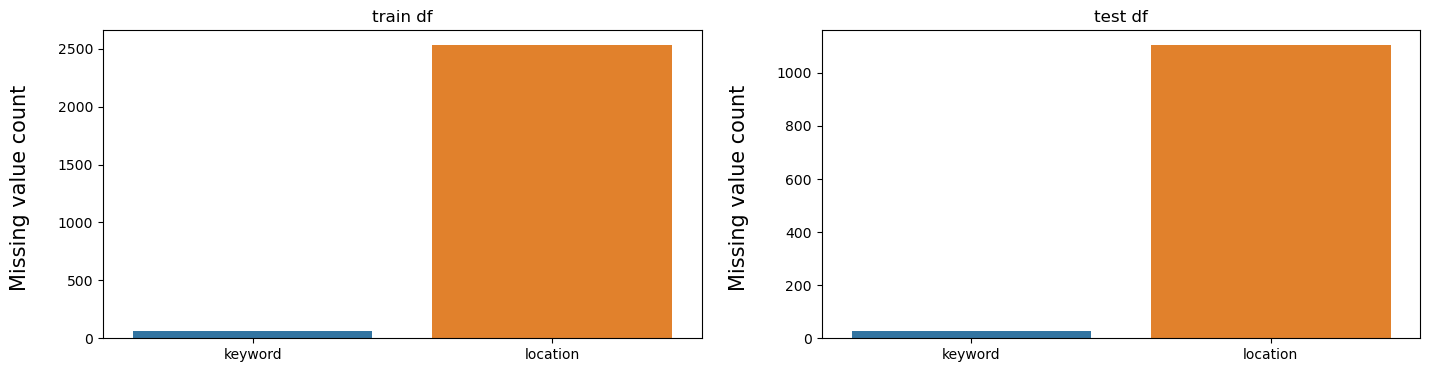

In [5]:
missing_cols = ['keyword', 'location']
fig, axes = plt.subplots(ncols = 2, figsize=(17,4), dpi = 100)

sns.barplot(x=train_df[['keyword', 'location']].isnull().sum().index, y = train_df[['keyword', 'location']].isnull().sum().values, ax = axes[0])
sns.barplot(x=test_df[['keyword', 'location']].isnull().sum().index, y = test_df[['keyword', 'location']].isnull().sum().values, ax = axes[1])

axes[0].set_ylabel('Missing value count ', size = 15, labelpad = 20)
axes[0].set_title('train df')
axes[1].set_ylabel('Missing value count ', size = 15, labelpad = 20)
axes[1].set_title('test df')

#Fill NA with no_keyword or no_location
for df in [train_df, test_df]:
    for col in ['keyword', 'location']:
        df[col] = df[col].fillna(f'no_{col}')


unique values:
TRAINING
keywords =  222
locations =  3342

TEST
keywords =  222
locations =  1603


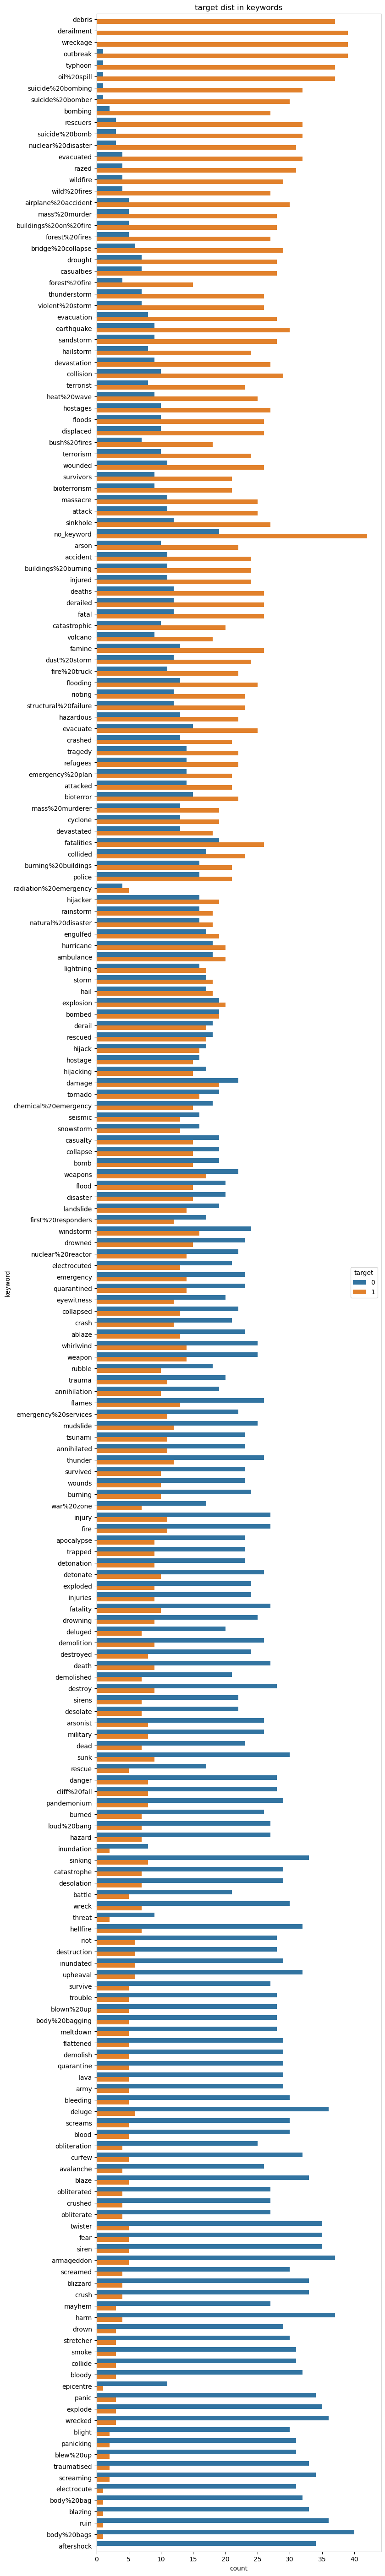

In [6]:
#count unique values for keywords  
print('unique values:')
print('TRAINING')
print('keywords = ', train_df['keyword'].nunique())
print('locations = ', train_df['location'].nunique())
print()
print('TEST')
print('keywords = ', test_df['keyword'].nunique())
print('locations = ', test_df['location'].nunique())

#Plot the distribution of each keyword corresponding to target 1
train_df['target_kw_mean'] = train_df.groupby('keyword')['target'].transform('mean')

fig = plt.figure(figsize=(8,72), dpi = 100)

sns.countplot(
    y = train_df.sort_values(by='target_kw_mean', ascending=False)['keyword'],
    hue = train_df.sort_values(by='target_kw_mean', ascending=False)['target'],
)
plt.title('target dist in keywords')

#drop this new column, for plotting only
train_df.drop(columns=['target_kw_mean'], inplace=True)


### explore meta features:
    hypothesis:
        - non-disaster usually come from users --> typos and errors
        - disaster usually come from agency --> less typos and errors
        these can be used as meta features:
            - word_count number of words in text
            - unique_word_count number of unique words in text
            - stop_word_count number of stop words in text
            - url_count number of urls in text
            - mean_word_length average character count in words
            - char_count number of characters in text
            - punctuation_count number of punctuations in text
            - hashtag_count number of hashtags (#) in text
            - mention_count number of mentions (@) in text
        ==> plot these meta data

In [7]:
sample = '''All residents asked to 'shelter in place' are being notified by officers. No other evacuation or shelter in place orders are expected'''
print([ s for s in sample.split(' ') if s in STOPWORDS])

['to', 'in', 'are', 'being', 'by', 'other', 'or', 'in', 'are']


In [13]:
def metadata(df):
    df['word_count'] = df['text'].apply(lambda x: len(str(x).split()))
    df['unique_word_count'] = df['text'].apply(lambda x: len(set(str(x).split())))
    df['stop_word_count'] = df['text'].apply(lambda x: len([str(word) for word in x.split() if word in STOPWORDS]))
    df['url_count'] = df['text'].apply(lambda x: len([url for url in x.split() if 'http' in url or 'https' in url]))
    df['mean_word_length'] = df['text'].apply(lambda x: np.mean([len(w) for w in x.split()]))
    df['char_count'] = df['text'].apply(lambda x: len(str(x)))
    df['punct_count'] = df['text'].apply(lambda x: len([c for c in x if c in string.punctuation]))
    df['hashtag_count'] = df['text'].apply(lambda x: len([c for c in x if c == '#']))
    df['mention_count'] = df['text'].apply(lambda x: len([c for c in x if c == '@']))

metadata(train_df)
metadata(test_df)

print(train_df.head())

train_df.to_csv('processed_train.csv')

   id     keyword     location  \
0   1  no_keyword  no_location   
1   4  no_keyword  no_location   
2   5  no_keyword  no_location   
3   6  no_keyword  no_location   
4   7  no_keyword  no_location   

                                                text  target  word_count  \
0  Our Deeds are the Reason of this #earthquake M...       1          13   
1             Forest fire near La Ronge Sask. Canada       1           7   
2  All residents asked to 'shelter in place' are ...       1          22   
3  13,000 people receive #wildfires evacuation or...       1           8   
4  Just got sent this photo from Ruby #Alaska as ...       1          16   

   unique_word_count  stop_word_count  url_count  mean_word_length  \
0                 13                5          0          4.384615   
1                  7                0          0          4.571429   
2                 20                9          0          5.090909   
3                  8                1          0          

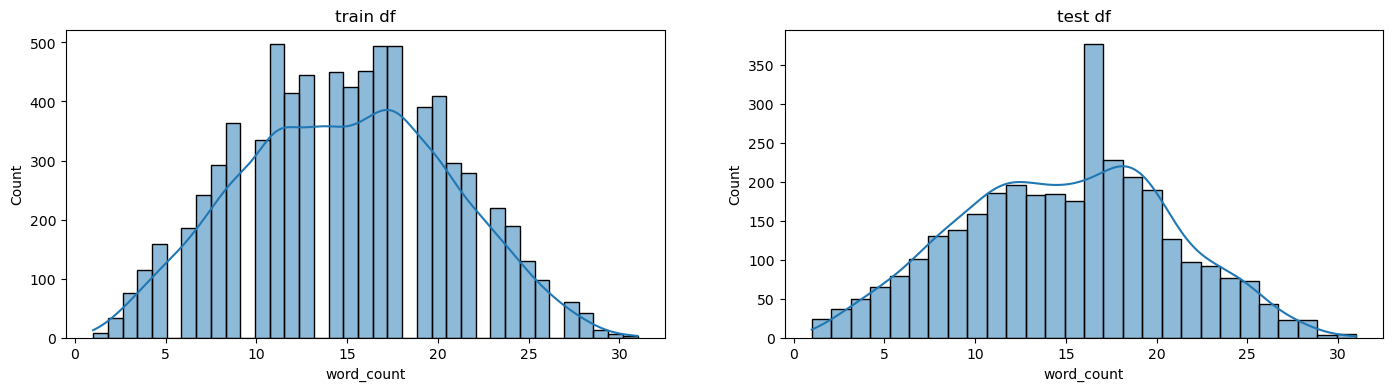

In [15]:
def plot_hist(train, test, column):
    # sns.barplot(x=train_df[['keyword', 'location']].isnull().sum().index, y = train_df[['keyword', 'location']].isnull().sum().values, ax = axes[0])
    fig, axes = plt.subplots(ncols = 2, figsize=(17,4), dpi = 100)
    sns.histplot(
        data = train, 
        x=column,
        kde=True,
        ax=axes[0]
    )
    axes[0].set_title('train df')
    sns.histplot(
        data = test, 
        x=column,
        kde=True,
        ax=axes[1]
    )
    axes[1].set_title('test df')

for column in ['word_count', 'unique_word_count', ]

plot_hist(train_df, test_df)




3. explore target data and its relation to n-grams:
    - plot yes / no dist pie plot ( see %) and hist plot
    - explore n-grams and target
        1. unigram
        2. 2-grams ( bigram)
        3. 3 grams (trigram)

4. Embedding and text cleaning
    - build vocab:
        tip: it's better to make vocab as close to pretrained embedding
        check embedding coverage 

    - clean the text:
        1. remove punctuation
        2. remove special words
        3. expand contractions
        4. remove URLs
        5. correct tyops and slang
5. Misampled labels 

6. Cross-validation

7. Training the model